# Sentiment Model Training
Train and debug sentiment analysis model for hotel comments.

## Thư viện nên dùng để train AI sentiment

- pandas: xử lý dữ liệu
- scikit-learn: vector hóa, train/test split, mô hình, đánh giá
- nltk hoặc spaCy: tiền xử lý nâng cao (tokenize, stopwords, lemmatization)
- joblib hoặc pickle: lưu mô hình
- matplotlib/seaborn: trực quan hóa dữ liệu, kết quả
- transformers (HuggingFace): nếu muốn dùng mô hình BERT, DistilBERT, ...
- tensorflow/keras: nếu muốn thử mô hình LSTM

In [2]:
import tensorflow
print("tensorflow version:", tensorflow.__version__)

tensorflow version: 2.19.0


In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Tải dữ liệu stopwords và wordnet nếu chưa có
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Loại bỏ stopwords và lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Ghép lại thành chuỗi
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to C:\Users\BINH
[nltk_data]     MINH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\BINH
[nltk_data]     MINH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached ml_dtypes-0.5.1-cp39-cp39-win_amd64.whl (209 kB)
  Using cached h5py-3.13.0-cp39-cp39-win_amd64.whl (3.0 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached protobuf-5.29.4-cp39-cp39-win_amd64.whl (434 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached wrapt-1.17.2-cp39-cp39-win_amd64.whl (38 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
     ---------------------------------------- 1.4/1.4 MB 796.9 kB/s eta 0:00:00
  Using cached absl_py-2.2.2-py3-none-any.whl (135 kB)
  Using cached grpcio-1.71.0-cp39-cp39-win_amd64.whl (4.3 MB)
  Using cached requests-2.32.3-py3-none-an

You should consider upgrading via the 'E:\Workspace\SmartHotel\AI_SmartHotel\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
# Đọc dữ liệu từ file CSV
# Dữ liệu phải có 2 trường: Review, Rating (1-5)
df = pd.read_csv('../data/tripadvisor_hotel_reviews.csv')
df = df.dropna(subset=["Review", "Rating"])
df["Rating"] = df["Rating"].astype(int)

# Áp dụng tiền xử lý cho toàn bộ dữ liệu
df["Review_clean"] = df["Review"].apply(preprocess_text)
df[["Review", "Review_clean"]].head()

,Review,Review_clean
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...


Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64
Số lượng từng rating:
Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64
Sau cân bằng:
Rating
1    1421
2    1421
3    1421
4    1421
5    1421
Name: count, dtype: int64


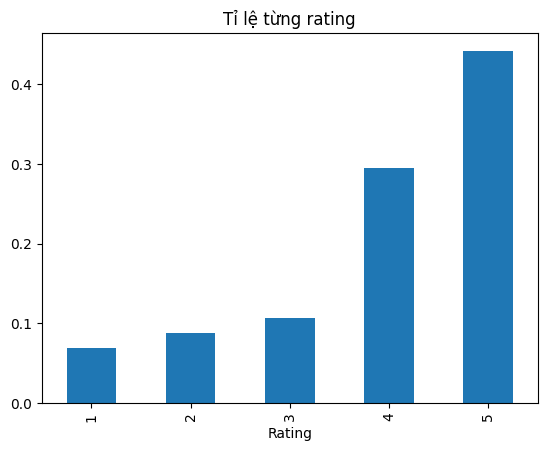

In [5]:

# Thống kê số lượng review cho từng rating
print(df["Rating"].value_counts().sort_index())
df["Rating"].value_counts(normalize=True).sort_index().plot(kind='bar', title='Tỉ lệ từng rating')

# Thống kê lại số lượng từng rating
print("Số lượng từng rating:")
print(df["Rating"].value_counts().sort_index())

# Cân bằng lại dữ liệu (undersample cho mỗi rating)
min_count = df["Rating"].value_counts().min()
df_balanced = df.groupby("Rating").sample(n=min_count, random_state=42)
print("Sau cân bằng:")
print(df_balanced["Rating"].value_counts().sort_index())

In [6]:
# Chuẩn bị dữ liệu cho LSTM
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced["Review_clean"])
X = tokenizer.texts_to_sequences(df_balanced["Review_clean"])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [7]:
# Encode label về dạng số liên tục từ 0
le = LabelEncoder()
y = le.fit_transform(df_balanced["Rating"])
y_cat = to_categorical(y)

In [7]:
# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

In [8]:
# Xây dựng mô hình LSTM
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build model để hiển thị đúng summary
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

e:\Workspace\SmartHotel\AI_SmartHotel\venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,165 (5.42 MB)

 Trainable params: 1,420,165 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9735 - loss: 0.0930 - val_accuracy: 0.4877 - val_loss: 3.5032
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9735 - loss: 0.0930 - val_accuracy: 0.4877 - val_loss: 3.5032
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.9799 - loss: 0.0823 - val_accuracy: 0.4525 - val_loss: 3.6917
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.9799 - loss: 0.0823 - val_accuracy: 0.4525 - val_loss: 3.6917
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9721 - loss: 0.1097 - val_accuracy: 0.4821 - val_loss: 3.7687
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9721 - loss: 0.1097 - val_accuracy: 0.4821 - val_loss: 3.7687
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9900 - loss: 0.0495 - val_accuracy: 0.4666 - val_loss: 4.0056
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9900 - loss: 0.0495 - val_accu

In [12]:
# Đánh giá
import numpy as np
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), digits=3))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
              precision    recall  f1-score   support

           1      0.705     0.520     0.599       294
           2      0.409     0.505     0.452       283
           3      0.380     0.389     0.385       285
           4      0.357     0.333     0.345       270
           5      0.606     0.651     0.628       289

    accuracy                          0.482      1421
   macro avg      0.491     0.480     0.482      1421
weighted avg      0.495     0.482     0.484      1421

              precision    recall  f1-score   support

           1      0.705     0.520     0.599       294
           2      0.409     0.505     0.452       283
           3      0.380     0.389     0.385       285
           4      0.357     0.333     0.345       270
           5      0.606     0.651     0.628       289

    accuracy                          0.482      1421
   macro avg      0.491     0.480     0.482      14

In [8]:
import pickle

# Lưu tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Lưu label_encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [13]:
# Lưu mô hình
model.save("../models/sentiment_lstm_model.h5")

In [22]:
# Hàm dự đoán rating cho 1 review_text
def predict_rating(review_text: str):
    # Tiền xử lý giống train
    review_clean = preprocess_text(review_text)
    seq = tokenizer.texts_to_sequences([review_clean])
    seq_pad = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    pred_prob = model.predict(seq_pad)
    pred_label = pred_prob.argmax(axis=1)[0]
    rating = le.inverse_transform([pred_label])[0]
    return rating

# Ví dụ sử dụng:
test_review = "warwick bad good reviews warwick shocks staff quite rude rooms fairly dirty, cut asked bandaid did not, requested bottle opener did not better service"
print("Dự đoán rating:", predict_rating(test_review))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Dự đoán rating: 2
Dự đoán rating: 2
